<h1 align="center">Linear Classifiers</h1> 

In [11]:
import os
import numpy as np
import seaborn as sns
import _pickle as pickle

from matplotlib.colors import ListedColormap
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons, make_circles, make_classification

%matplotlib inline
sns.set_context("notebook", font_scale=1.5)
import random
from IPython import display
from scipy import optimize

<h1 align="center">2D datasets</h1> 

In [6]:
X, y = make_classification(n_features=2, n_redundant=0, n_informative=2)
X += np.random.random(X.shape)

datasets = [make_moons(noise=0.1), make_circles(noise=0.1, factor=0.5), (X, y)]

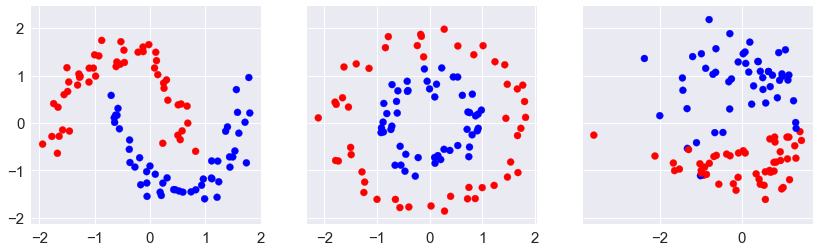

In [7]:
pylab.rcParams['figure.figsize'] = 14, 4
pl = plt.subplots(1, len(datasets), sharex='col', sharey='row')
for i, (X, y) in enumerate(datasets):
    X = StandardScaler().fit_transform(X)
    pl[1][i].scatter(X[:, 0], X[:, 1], c=y, cmap=ListedColormap(['#FF0000', '#0000FF']))

<h1 align="center">CIFAR dataset</h1> 

In [8]:
def load_CIFAR_batch(filename):
    with open(filename, 'rb') as f:
        datadict = pickle.load(f)
        X = datadict['data']
        Y = datadict['labels']
        X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float")
        Y = np.array(Y)
        return X, Y

def load_CIFAR10(ROOT):
    xs = []
    ys = []
    for b in range(1, 6):
        f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
        X, Y = load_CIFAR_batch(f)
        xs.append(X)
        ys.append(Y)    
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    del X, Y
    Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
    return Xtr, Ytr, Xte, Yte

In [ ]:
cifar10_dir = './data/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

In [ ]:
pylab.rcParams['figure.figsize'] = (14.0, 5.0) 
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 4
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        pylab.subplot(samples_per_class, num_classes, plt_idx)
        pylab.imshow(X_train[idx].astype('uint8'))
        pylab.axis('off')
        if i == 0:
            pylab.title(cls)
pylab.show()

## Linear Model

## $$y_{predict}(x) = sign(<w, x>)~~~~~~margin(x, y) = y \cdot sign(<w, x>)$$

### Простой пример классфикации 

In [ ]:
x, w, y_true = [0.01, 1], [-0.1, 0.15], -1
print 'margin', y_true*np.dot(x, w), 'label', np.sign(np.dot(x, w))

### Визуализация

In [ ]:
pylab.rcParams['figure.figsize'] = (12.0, 5.0) 

xx, yy = np.meshgrid(np.linspace(0, 1, 20), np.linspace(0, 1, 20))
y_pred = w[0]*xx + w[1]*yy

pl = plt.subplots(1, 2, sharex='col', sharey='row')

pl[1][0].set_xlim([0, 1])
pl[1][0].set_ylim([0, 1])

cax = pl[1][0].pcolormesh(xx, yy, y_pred, cmap='rainbow')
pl[1][0].scatter(xx, yy, c=y_pred, alpha=0.8, cmap='rainbow')
pylab.colorbar(cax, ticks=[-1, 0, 1])

pl[1][1].set_xlim([0, 1])
pl[1][1].set_ylim([0, 1])

cax = pl[1][1].pcolormesh(xx, yy, np.sign(y_pred), cmap='rainbow')
pl[1][1].scatter(xx, yy, c=np.sign(y_pred), alpha=0.8, cmap='rainbow')

<h1 align="center">General optimization problem for Linear Classifiers</h1> 

## $$L = \frac{1}{n} \sum_i^n L_i(x_i, y_i^{real}, y_i^{predict}(w); w) \rightarrow \min_w ~~~~~~ y^{predict}(x) = <x, w>$$

Loss functions:
    - Hinge Loss 
## $$L_i(x, y; w) = max(0, 1 - y\cdot<w, x>)$$
    - Loistic Loss 
## $$L_i(x, y; w) = log(1 + e^{-y\cdot<w, x>})$$
    - Squared Loss
## $$L_i(x, y; w) = log(1 - y\cdot<w, x>)^2$$

In [ ]:
pylab.rcParams['figure.figsize'] = (7.0, 7.0) 
x = np.linspace(-1, 2.5)
pylab.plot(x, map(lambda m: np.max([0, 1 - m]), x), label='hinge')
pylab.plot(x, map(lambda m: np.log(1 + e**(-m)), x), label='logistic')
pylab.plot(x, map(lambda m: (1 - m)**2, x), label='squared')
pylab.ylabel('Loss')
pylab.xlabel('Margin')

### Нелинейная линейная модель

In [9]:
def expand(X):
    X_ = np.zeros((X.shape[0], 6))
    X_[:,0:2] = X
    X_[:,2:4] = X**2
    X_[:,4] = X[:,0] * X[:,1]
    X_[:,5] = 1;
    return X_

# How to train 

<h2 align="center">Как вычислять градиент</h2> 

### Матричные производные

Найти производные приведенных функций по w, в матричной форме

## $$f(w) = <x, w>$$

## $$f(w) = \sum_i log(1-e^{-y_i <x_i, w>})$$

### Численное дифиренцирование

<img src="https://github.com/ml-mipt/ml-mipt-part1/blob/master/2016/seminars/05_linear/img/finnit_diff.png?raw=true">

In [ ]:
#https://en.wikipedia.org/wiki/Numerical_differentiation

### Символьное дифиренцирование

In [14]:
import theano
import theano.tensor as T

RuntimeError: To use MKL 2018 with Theano you MUST set "MKL_THREADING_LAYER=GNU" in your environement.

In [ ]:
my_scalar = T.scalar(name='input',dtype='float64')
scalar_squared = T.sum(my_scalar**2)
derivative = T.grad(scalar_squared, my_scalar)

fun = theano.function([my_scalar],scalar_squared)
grad = theano.function([my_scalar],derivative) 

In [ ]:
x = np.linspace(-3,3)
x_squared = map(fun,x)
x_squared_der = map(grad,x)

pylab.plot(x, x_squared,label="x^2")
pylab.plot(x, x_squared_der, label="derivative")
pylab.legend()

In [ ]:
def classify(X, w):
    return np.sign(1.0 / (1.0 + np.exp(X.dot(w))) - 0.5)

w = T.vector("w", dtype='float64')
input_X = T.matrix("X", dtype='float64')
input_y = T.vector("y", dtype='float64')


margin = -input_y*input_X.dot(w)

loss = T.log(1+T.exp(-margin)).mean()
grad = T.grad(loss, w)
hess = T.hessian(loss, w)

loss_function = theano.function([input_X, input_y, w], loss)
grad_function = theano.function([input_X, input_y, w], grad)
hess_function = theano.function([input_X, input_y, w], hess)

<h2 align="center">Выпуклая задача</h2> 
    - Что такое выпуклая функция
    - Сколько оптимумов имеет выпуклая задача?
    - Как понять что задача выпуклая?

In [ ]:
display.Image('img/conv.jpg')

<h2 align="center">Оптимизация</h2> 

In [ ]:
def visualize(X, y, w, loss, n_iter, h=0.01):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    plt.clf()
    Z = classify(expand(np.c_[xx.ravel(), yy.ravel()]), w)
    Z = Z.reshape(xx.shape)
    plt.subplot(1,2,1)
    plt.contourf(xx, yy, Z, cmap='rainbow', alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='rainbow')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.subplot(1,2,2)
    plt.plot(loss)
    ymin, ymax = plt.ylim()
    plt.ylim(0, ymax)
    display.clear_output(wait=True)
    display.display(plt.gcf())

In [ ]:
def viz_opt(func, gradf, hessf, X, y, get_direction, w0=None, batch_size=None, alpha=None, mu=0.9, n_iter=10):
    a = None
    loss1 = np.zeros(n_iter)
    plt.figure(figsize=(12,5))
    ind = np.arange(X.shape[0])
    
    X_, y_ = X, y
    w, d = np.zeros(X_.shape[1]), np.zeros(X_.shape[1])
    
    for i in range(n_iter):
        if batch_size:
            ind = random.sample(range(X.shape[0]), batch_size)
            X_, y_ = X[ind], y[ind]
            
        loss1[i] += loss_function(X_, y_, w)
        visualize(X_, y_, w, loss1, n_iter)
        
        d = get_direction(X_, y_, w, gradf, hessf, d)
        
        if not alpha:
            f = lambda w: loss_function(X_, y_, w)
            g = lambda w: grad_function(X_, y_, w)
            a = optimize.line_search(f, g, w, d)[0]
            
        if not a:
            a = 1e-4
            
        w = w + a*d
        
    visualize(X, y, w, loss1, n_iter)
    
    q = plt.clf()
    pylab.show()

### Градинтный спуск

## $$x_{k+1} = x_k - \Delta f(x_k)$$

Метод градиентного спуска обладает линейной скоростью сходимости. 
Что достачтоно меленно.

In [ ]:
def expand(X):
    return X

def gd(X, y, w, gradf, hessf, dold):
    return -grad_function(X, y, w)

for X, y in datasets:
    X, y = expand(X), -2*(y-0.5)
    a = viz_opt(loss_function, grad_function, hess_function, X, y, gd) 

display.clear_output()

In [ ]:
def expand(X):
    X_ = np.zeros((X.shape[0], 6))
    X_[:,0:2] = X
    X_[:,2:4] = X**2
    X_[:,4] = X[:,0] * X[:,1]
    X_[:,5] = 1;
    return X_

for X, y in datasets:
    X, y = expand(X), -2*(y-0.5)
    a = viz_opt(loss_function, grad_function, hess_function, X, y, gd) 

display.clear_output()

### Нютон (HF, BFGS)

## $$x_{k+1} = x_k - \Delta^2 f(x_k) \Delta f(x_k)^T$$

Методы второго порядка -- намного быстрее, но как правило дорогие тк требуют хранения гессиана.

Некоторые методы второго порядка лишены жтого недостатка, при необходимсти используйте BFGS или HF Newton. 

In [ ]:
def nw(X, y, w, gradf, hessf, dold):
    return -np.linalg.inv(hessf(X, y, w)).dot(grad_function(X, y, w))

for X, y in datasets:
    X, y = expand(X), -2*(y-0.5)
    a = viz_opt(loss_function, grad_function, hess_function, X, y, nw) 

display.clear_output()

### Стахастичиский град спуск, моментум, нестеров

Что делать если в функции большая сумма? давайте считать градиент только по случайной подвыборке

## $$x_{k+1} = x_k -  \Delta \hat{f}(x_k)^T$$

In [ ]:
def gd(X, y, w, gradf, hessf, dold):
    return -grad_function(X, y, w)

for X, y in datasets:
    X, y = expand(X), -2*(y-0.5)
    a = viz_opt(loss_function, grad_function, hess_function, X, y, gd, batch_size=10) 

display.clear_output()

## $$x_{k+1} = x_k - E \Delta \hat{f}(x_k)^T$$

In [ ]:
def momentum(X, y, w, gradf, hessf, dold, mu=0.9):
    return mu * dold - (1-mu) * grad_function(X, y, w)

for X, y in datasets:
    X, y = expand(X), -2*(y-0.5)
    a = viz_opt(loss_function, grad_function, hess_function, X, y, momentum, batch_size=10) 

display.clear_output()

## $$x_{k+1} = x_k - E \Delta \hat{f}(x_k-\alpha E \Delta \hat{f}_{k-1})^T$$

In [ ]:
def nesterow(X, y, w, gradf, hessf, dold, mu=0.9, alpha=1e-3):
    return mu * dold - (1-mu) * grad_function(X, y, w + alpha*dold)

for X, y in datasets:
    X, y = expand(X), -2*(y-0.5)
    a = viz_opt(loss_function, grad_function, hess_function, X, y, nesterow, batch_size=10) 

display.clear_output()

### Выбор шага 

Неточная одномерная оптимизация Wolfe conditions, константа наверняка плохо

## $$f(\mathbf{x}_k+\alpha_k\mathbf{p}_k)\leq f(\mathbf{x}_k)+c_1\alpha_k\mathbf{p}_k^{\mathrm T}\nabla f(\mathbf{x}_k)$$

## $$\mathbf{p}_k^{\mathrm T}\nabla f(\mathbf{x}_k+\alpha_k\mathbf{p}_k) \geq c_2\mathbf{p}_k^{\mathrm T}\nabla f(\mathbf{x}_k)$$

### Выбор начального приближения

- Обычно случайный близкий к нулю вектор
- Если задача не выпклая то лучше несколько случайных приближений


<h1 align="center">Advantages and Disadvantages</h1> 

Достоинства:
    - Быстрые
    - Работают
    - Интерпретируемы
    - Применимы к большим данным
    - Можно обучать онлайн
Недостатки:
    - Не всегда хороши

<h1 align="center"> When are you should use linear models?</h1> 